In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset
from scipy.stats import sem

import tqdm
tqdm.tqdm.pandas()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
mpl_latex.enable_production_mode()

In [6]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack, SPARSE_ATTACKS
from rgnn_at_scale.io import Storage
from rgnn_at_scale.models import DenseGCN, GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.utils import accuracy

In [7]:
labels_to_plot = [
    'Vanilla GDC',
    'Soft Medoid GDC (T=0.5)',
    'Soft Median GDC (T=0.2)'
]

In [8]:
dataset = 'cora_ml'
binary_attr = False
attack = 'PGD'
seeds = [0, 1, 5]
artifact_dir = 'cache'
pert_adj_storage_type = 'evasion_transfer_attack_adj'
pert_attr_storage_type = 'evasion_transfer_attack_attr'
model_storage_type = 'pretrained'
device = 0
epsilons = [0, 0.01, 0.05, 0.1, 0.25]
surrogate_params = {
    'n_filters': 64,
    'dropout': 0.5,
    'train_params': {
        'lr': 1e-2,
        'weight_decay': 1e-3,
        'patience': 100,
        'max_epochs': 3000
    }
}
attack_params = {
    'loss_type': 'tanhCW'
}
display_steps = 10
model_label = None

In [9]:
graph = prep_graph(dataset, device, binary_attr=binary_attr, return_original_split=dataset.startswith('ogbn'))
attr, adj, labels = graph[:3]
if len(graph) == 3:
    idx_train, idx_val, idx_test = split(labels.cpu().numpy())
else:
    idx_train, idx_val, idx_test = graph[3]['train'], graph[3]['valid'], graph[3]['test']
n_features = attr.shape[1]
n_classes = int(labels.max() + 1)

In [10]:
results = []
for seed in seeds:
    params = dict(dataset=dataset, binary_attr=binary_attr, seed=seed, attack=attack,
                  surrogate_params=surrogate_params, attack_params=attack_params)
    storage = Storage(artifact_dir)

    adj_per_eps = []
    attr_per_eps = []
    for epsilon in epsilons:
        if epsilon == 0:
            continue

        pert_adj = storage.load_artifact(pert_adj_storage_type, {**params, **{'epsilon': epsilon}})
        pert_attr = storage.load_artifact(pert_attr_storage_type, {**params, **{'epsilon': epsilon}})
        if pert_adj is None or pert_attr is None:
            # Due to the greedy fashion we only use the existing adjacency matrices if all do exist
            adj_per_eps = []
            attr_per_eps = []
            break

        adj_per_eps.append(pert_adj)
        attr_per_eps.append(pert_attr)
    
    if epsilons[0] == 0:
        adj_per_eps.insert(0, adj.to('cpu'))
        attr_per_eps.insert(0, attr.to('cpu'))
    
    model_params = dict(dataset=dataset, binary_attr=binary_attr, seed=seed)
    if model_label is not None and model_label:
        model_params['label'] = model_label
    models_and_hyperparams = storage.find_models(model_storage_type, model_params)

    with torch.no_grad():
        for model, hyperparams in models_and_hyperparams:
            if hyperparams['label'] not in labels_to_plot:
                continue
            model = model.to(device)
            model.eval()
            
            eps, adj_perturbed, attr_perturbed = epsilons[0], adj_per_eps[0], attr_per_eps[0]
            edge_idx, edge_weight = model._cache_if_option_is_set(model._preprocess_adjacency_matrix,
                                                                  attr_perturbed.to(device), 
                                                                  adj_perturbed._indices().to(device), 
                                                                  adj_perturbed._values().to(device))

            x_0_0 = model.layers[0]((attr_perturbed.to(device), edge_idx, edge_weight))
            x_0_1 = model.layers[1]((x_0_0, edge_idx, edge_weight))

            for eps, adj_perturbed, attr_perturbed in zip(epsilons[1:], adj_per_eps[1:], attr_per_eps[1:]):
                # In case the model is non-deterministic to get the results either after attacking or after loading
                torch.manual_seed(seed)
                np.random.seed(seed)

                pred_logits_target = model(attr_perturbed.to(device), adj_perturbed.to(device))
                acc_test_target = accuracy(pred_logits_target, labels.to(device), idx_test)
                
                edge_idx, edge_weight = model._cache_if_option_is_set(model._preprocess_adjacency_matrix,
                                                                      attr_perturbed.to(device), 
                                                                      adj_perturbed._indices().to(device), 
                                                                      adj_perturbed._values().to(device))

                x_0 = model.layers[0]((attr_perturbed.to(device), edge_idx, edge_weight))
                x_1 = model.layers[1]((x_0, edge_idx, edge_weight))
                results.append({
                    'label': hyperparams['label'],
                    'seed': seed,
                    'epsilon': eps,
                    'accuracy': acc_test_target,
                    'error_0': torch.norm(x_0_0 - x_0, dim=1).mean().item(),
                    'error_1': torch.norm(x_0_1 - x_1, dim=1).mean().item()
                })

In [11]:
df = pd.DataFrame(results)

df = pd.merge(df, df[df.label == 'Vanilla GDC'], on=['seed', 'epsilon'], suffixes=('', '_y'))
df['error_0_rel'] = df['error_0'] / df['error_0_y']
df['error_1_rel'] = df['error_1'] / df['error_1_y']
df.label = df.label.apply(
    lambda el: el.replace(' (T=0.5)', '').replace(' (T=0.2)', '').replace(' GDC', '').replace('Vanilla', 'Weighted sum')
)

df

,label,seed,epsilon,accuracy,error_0,error_1,label_y,accuracy_y,error_0_y,error_1_y,error_0_rel,error_1_rel
0,Weighted sum,0,0.01,0.811067,0.021593,0.250988,Vanilla GDC,0.811067,0.021593,0.250988,1.000000,1.000000
1,Soft Medoid,0,0.01,0.818182,0.013995,0.166836,Vanilla GDC,0.811067,0.021593,0.250988,0.648120,0.664717
2,Soft Median,0,0.01,0.818972,0.016477,0.194622,Vanilla GDC,0.811067,0.021593,0.250988,0.763076,0.775425
3,Weighted sum,0,0.05,0.736759,0.065653,0.780323,Vanilla GDC,0.736759,0.065653,0.780323,1.000000,1.000000
4,Soft Medoid,0,0.05,0.798814,0.043039,0.507539,Vanilla GDC,0.736759,0.065653,0.780323,0.655549,0.650422
5,Soft Median,0,0.05,0.797233,0.050701,0.583779,Vanilla GDC,0.736759,0.065653,0.780323,0.772255,0.748126
6,Weighted sum,0,0.10,0.684190,0.103536,1.198594,Vanilla GDC,0.684190,0.103536,1.198594,1.000000,1.000000
7,Soft Medoid,0,0.10,0.777075,0.068713,0.778210,Vanilla GDC,0.684190,0.103536,1.198594,0.663658,0.649269
8,Soft Median,0,0.10,0.775099,0.080667,0.893739,Vanilla GDC,0.684190,0.103536,1.198594,0.779121,0.745656
9,Weighted sum,0,0.25,0.569565,0.173838,1.983291,Vanilla GDC,0.569565,0.173838,1.983291,1.000000,1.000000


In [21]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

sns.lineplot(
    x=df.epsilon.rename(r'Fract. pert. edges $\epsilon$'),
    y=df.error_0.rename('$L_2$ error'),
    hue=df.label,
    err_style="bars"
)

mpl_latex.savefig(f'latex/assets/global_pgd_error_0', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_pgd_error_0_legend',
    mod_label=lambda l: l,
    ncol=3
)
fig.axes[0].get_legend().remove()
mpl_latex.savefig(f'latex/assets/global_pgd_error_0_no_legend', fig, close_fig=False)

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [17]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

sns.lineplot(
    x=df.epsilon.rename(r'Fract. pert. edges $\epsilon$'),
    y=df.error_1.rename('$L_2$ error'),
    hue=df.label,
    err_style="bars"
)

mpl_latex.savefig(f'latex/assets/global_pgd_error_1', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_pgd_error_1_legend',
    mod_label=lambda l: l,
    ncol=3
)
fig.axes[0].get_legend().remove()
mpl_latex.savefig(f'latex/assets/global_pgd_error_1_no_legend', fig, close_fig=False)

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [19]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

sns.lineplot(
    x=df.epsilon.rename(r'Fract. pert. edges $\epsilon$'),
    y=df.error_0_rel.rename('Relative $L_2$ error'),
    hue=df.label,
    err_style="bars"
)

mpl_latex.savefig(f'latex/assets/global_pgd_relerror_0', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_pgd_relerror_0_legend',
    mod_label=lambda l: l,
    ncol=3
)
fig.axes[0].get_legend().remove()
mpl_latex.savefig(f'latex/assets/global_pgd_relerror_0_no_legend', fig, close_fig=False)

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [20]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)

sns.lineplot(
    x=df.epsilon.rename(r'Fract. pert. edges $\epsilon$'),
    y=df.error_1_rel.rename('Relative $L_2$ error'),
    hue=df.label,
    err_style="bars"
)

mpl_latex.savefig(f'latex/assets/global_pgd_relerror_1', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_pgd_relerror_1_legend',
    mod_label=lambda l: l,
    ncol=3
)
fig.axes[0].get_legend().remove()
mpl_latex.savefig(f'latex/assets/global_pgd_relerror_1_no_legend', fig, close_fig=False)

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


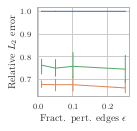

In [16]:
plt.gcf()